In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import db
import pam
import utils as ut
import features as ft
import dtw
import clustering_evaluation as ce
import seq2seq as s2s

import time

from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN
from scipy.cluster.hierarchy import linkage, ward, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import pairwise_distances,homogeneity_completeness_v_measure,silhouette_score,calinski_harabaz_score

In [2]:
DATA_PATH = "data/laurier/"
DATA_BASE = DATA_PATH + "laurier.sqlite"
SAVE_PATH = DATA_PATH + "generated_data/"
FRAME_PATH = DATA_PATH + "laurier.jpg"
VIDEO_PATH = DATA_PATH + "laurier.avi"
HOMOGRAPHY = DATA_PATH + "laurier-homography.txt"
DISTANCES = SAVE_PATH + "distances/cityblock_50.txt"

# Get the data

### Load trajectories from path

In [3]:
# get every trajectories in the database
trajectories_u = db.get_trajectories(DATA_BASE)

# number of best trajectories to keep for each object
nb_trajectories_per_object = 10

#trajectories ordered by object, database trajectory ids ordered by objects
trajectories_po,ids_po,nb_objects = db.get_trajectories_by_object(DATA_BASE)
trajectories_po,ids_po = db.filter_trajectories(nb_trajectories_per_object, trajectories_po, ids_po)
pixel_trajectories_po = [[ut.to_pixel(t,HOMOGRAPHY) for t in trajectories] for trajectories in trajectories_po]

#total number of selected trajectories
nb_trajectories = nb_trajectories_per_object * nb_objects

# list of every selected trajectory, 
trajectories = [t for o in trajectories_po for t in o]
# ids of every selected trajectory
ids = [i for o in ids_po for i in o]
# trajectories in pixel space, for displaying purposes only
pixel_trajectories = [ut.to_pixel(t,HOMOGRAPHY) for t in trajectories]

In [4]:
nb_objects

5

In [5]:
nb_trajectories

50

### Visualize selected trajectories in pixel space

The red dots are the beginnings of the trajectories, while the green ones are their ends

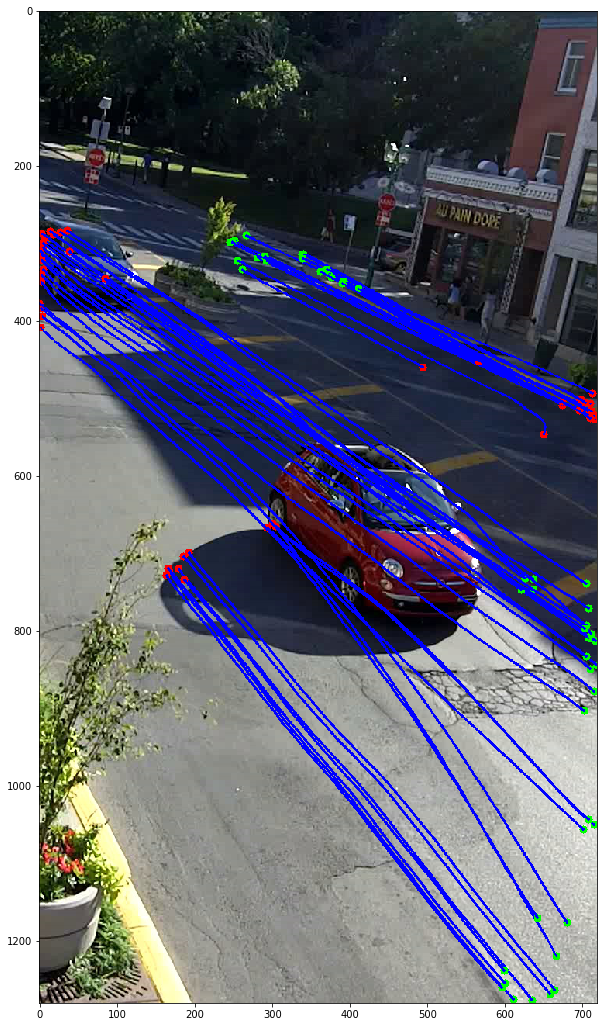

In [6]:
ut.plot_trajectories(FRAME_PATH,pixel_trajectories)

## Trajectory discretization

In [43]:
square_size = 0.66
discretized_trajectories = [dtw.discretize(trajectory,square_size) for trajectory in trajectories]

On the following plots we can see the trajectory number of points distribution before and after the discretization

(array([10.,  0.,  0.,  2., 13.,  1.,  7.,  3.,  7.,  7.]),
 array([ 40.,  52.,  64.,  76.,  88., 100., 112., 124., 136., 148., 160.]),
 <a list of 10 Patch objects>)

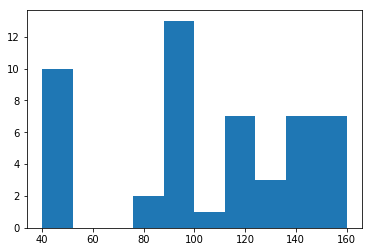

In [44]:
plt.hist([len(t) for t in trajectories])

(array([10.,  0.,  1.,  0.,  4., 12., 10.,  6.,  4.,  3.]),
 array([14. , 18.5, 23. , 27.5, 32. , 36.5, 41. , 45.5, 50. , 54.5, 59. ]),
 <a list of 10 Patch objects>)

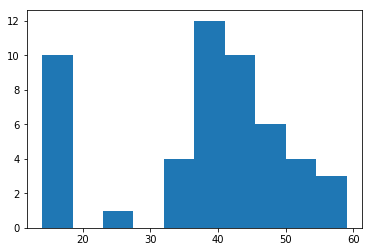

In [45]:
plt.hist([len(t) for t in discretized_trajectories])

### Effect of discretization on clustering quality

In [62]:
square_sizes = np.linspace(0.0, 1.0, num=10)
nb_clusters = nb_objects
values = []
for square_size in square_sizes:
    discretized_trajectories = [dtw.discretize(trajectory,square_size) for trajectory in trajectories]
    distance_matrix = dtw.compute_dtw_distance_matrix(discretized_trajectories)
    Z = linkage(squareform(distance_matrix), 'ward')
    clusters = fcluster(Z, nb_clusters, criterion='maxclust')
    _,_,v = homogeneity_completeness_v_measure(labels_true, clusters)
    values.append(v)

In [63]:
square_sizes[np.argmax(values)],np.max(values)

(0.6666666666666666, 0.8061414896014087)

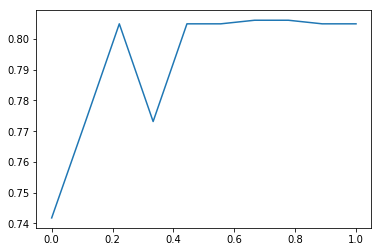

In [64]:
plt.plot(square_sizes,values)

### Compute distance matrix

In [65]:
start = time.time()
distance_matrix = dtw.compute_dtw_distance_matrix(discretized_trajectories)
print(time.time() - start)

4.71148395538


# Clustering evaluation

## Supervised

COnsidering the fact that, the trajectories are initially grouped by object, we can evaluate the quality of the clustering, using these groups as ground truth. And setting the number of clusters required to the number of objects in the database

In [66]:
labels_true = ce.get_ground_truth(ids,ids_po)   

## Hierarchical

In [67]:
nb_clusters = nb_objects
Z = linkage(squareform(distance_matrix), 'ward')
clusters = fcluster(Z, nb_clusters, criterion='maxclust')

In [68]:
homogeneity_completeness_v_measure(labels_true, clusters)

(0.7718256215254754, 0.8410964265818053, 0.8049735236382352)

## K-MEDOIDS

In [69]:
start = time.time()

medoids_idx, clusters =pam.pam(distance_matrix, nb_clusters)

print(time.time() - start)
homogeneity_completeness_v_measure(labels_true, clusters)

0.0781140327454


(0.87108976566598, 0.8822081346616855, 0.8766136971332149)

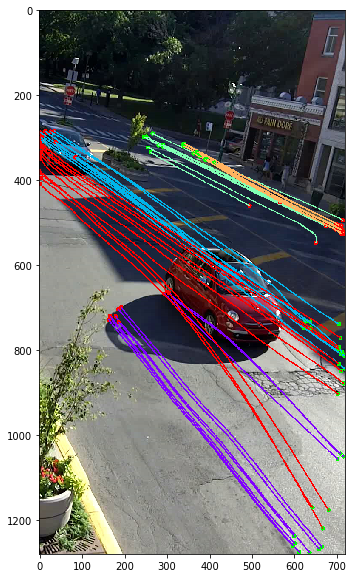

In [70]:
ut.plot_trajectories_by_groups(FRAME_PATH,pixel_trajectories_po)

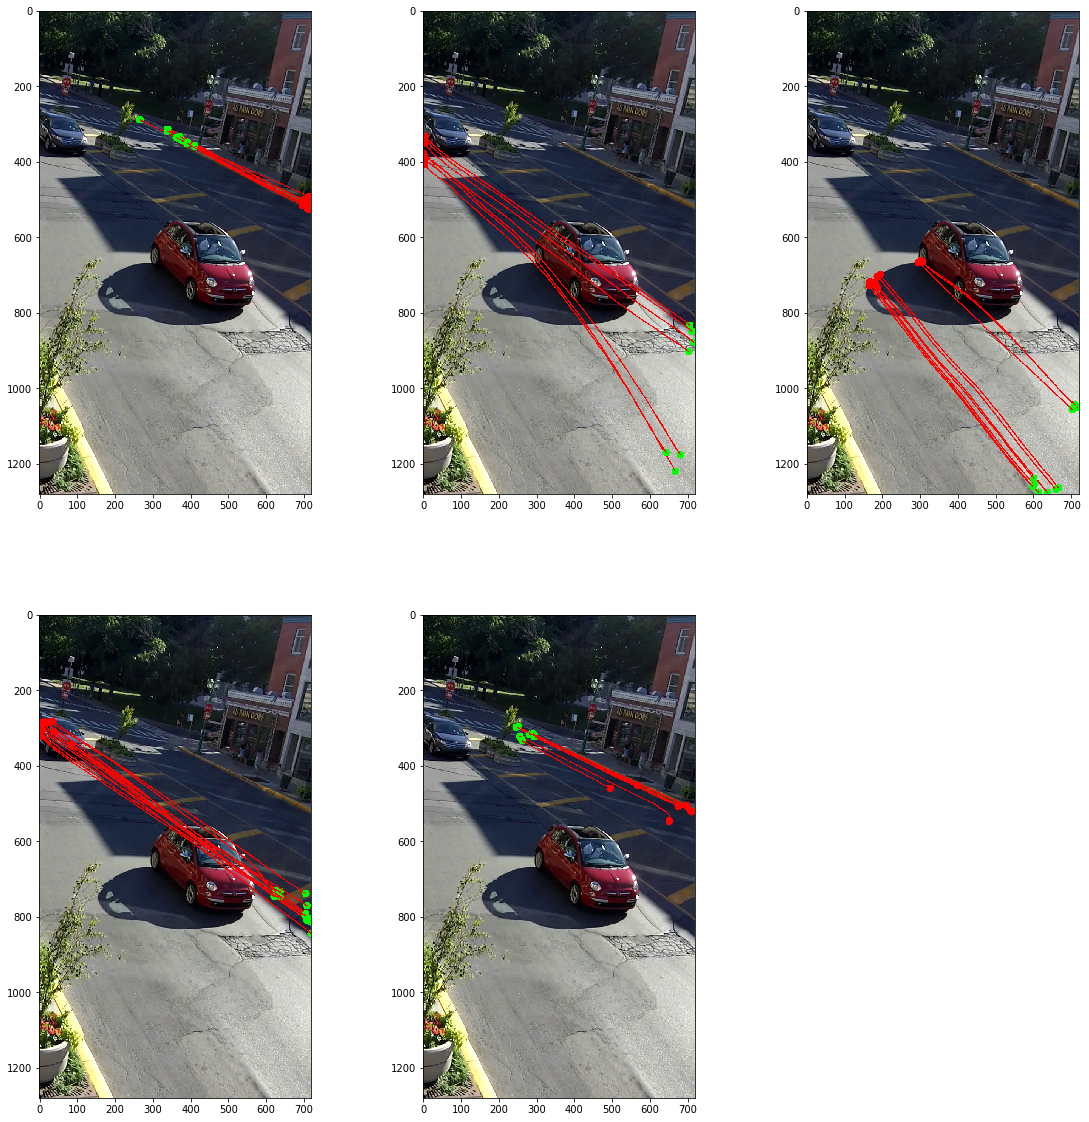

In [71]:
ut.display_clusters_oat_i(clusters,FRAME_PATH,pixel_trajectories)

## Unsupervised

### Hierarchical

In [72]:
max_clusters = nb_trajectories
silhouette = []
#calinski_index = []
for i in range(2,max_clusters):
    Z = linkage(squareform(distance_matrix), 'ward')
    clusters = fcluster(Z, i, criterion='maxclust')
    s = silhouette_score(distance_matrix, clusters, metric='precomputed')
    #c = calinski_harabaz_score(features, clusters) 
    silhouette.append(s)



In [73]:
np.argmax(silhouette)+2,np.max(silhouette)

(3, 0.8194690641005141)

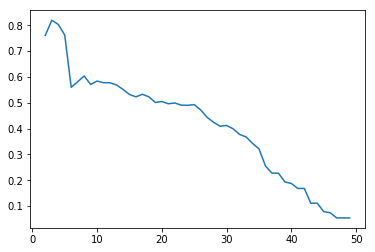

In [74]:
plt.plot(np.arange(2,max_clusters,1),silhouette)

### PAM

In [75]:
max_clusters = nb_trajectories
silhouette = []
#calinski_index = []
for i in range(2,max_clusters):
    #distance_matrix = pairwise_distances(features_pca,metric="manhattan")
    medoids_idx, clusters =pam.pam(distance_matrix, i)
    s = silhouette_score(distance_matrix, clusters, metric='precomputed')
    #c = calinski_harabaz_score(features, clusters) 
    silhouette.append(s)
    #calinski_index.append(c)

In [76]:
np.argmax(silhouette)+2,np.max(silhouette)

(3, 0.8304875283827385)

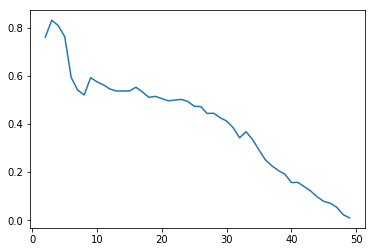

In [77]:
plt.plot(np.arange(2,max_clusters,1),silhouette)

In [78]:
nb_clusters = 3

In [81]:
medoids_idx, clusters =pam.pam(distance_matrix, nb_clusters)

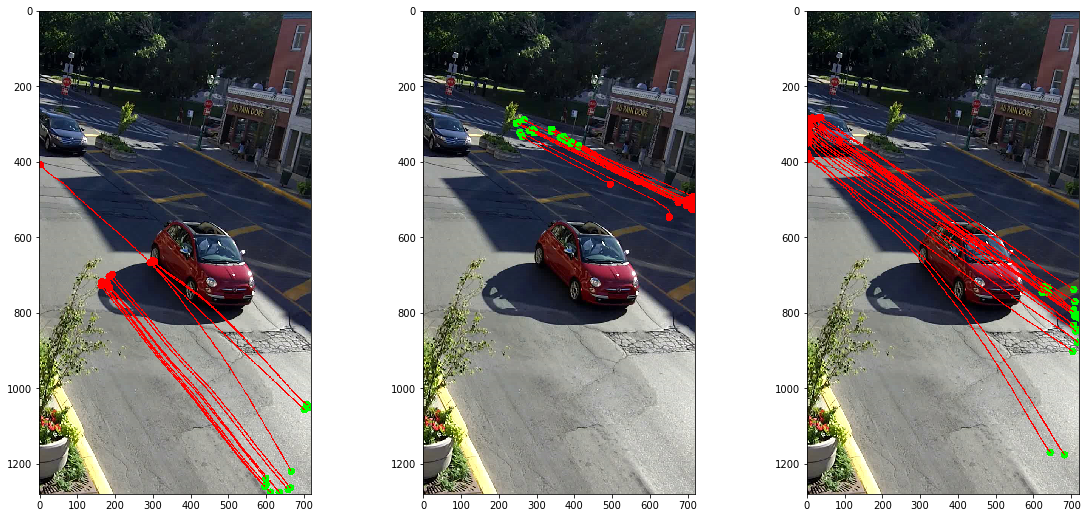

In [82]:
ut.display_clusters_oat_i(clusters,FRAME_PATH,pixel_trajectories)

### Stats about clusters

mean x value

<BarContainer object of 3 artists>

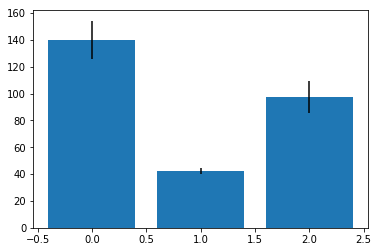

In [30]:
stats = ce.get_clusters_stats(trajectories,nb_clusters,clusters)
plt.bar(np.arange(0,nb_clusters),stats[:,0,0],yerr = stats[:,1,0])

mean y value

<BarContainer object of 3 artists>

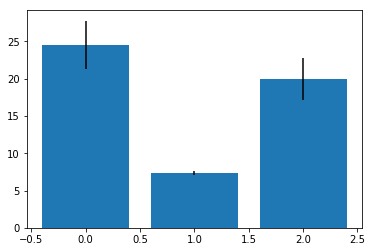

In [29]:
stats = ce.get_clusters_stats(trajectories,nb_clusters,clusters)
plt.bar(np.arange(0,nb_clusters),stats[:,0,1],yerr = stats[:,1,1])

mean speed value

<BarContainer object of 3 artists>

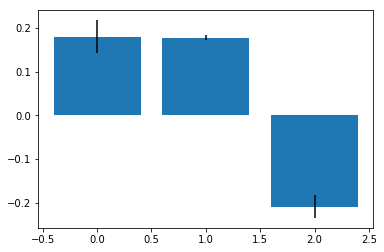

In [27]:
stats = ce.get_clusters_stats(trajectories,nb_clusters,clusters)
plt.bar(np.arange(0,nb_clusters),stats[:,0,2],yerr = stats[:,1,2])

mean rate of turn value

<BarContainer object of 3 artists>

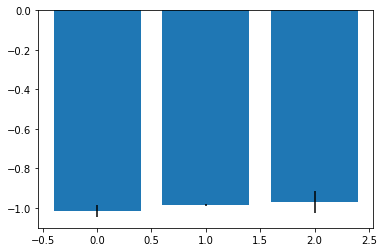

In [28]:
plt.bar(np.arange(0,nb_clusters),stats[:,0,3],yerr = stats[:,1,3])

# Observations/Conclusions

On a pu observer avec une méthode d'évaluation supervisée qu'une discrétisation  (0.666) permet d'améliorer le clustering. 

L'utilisation de la discrétisation augmente les performances de l'algorithme (en temps et en résultat). Pour l'algorithme de k-médoid, les performances son meilleures lors de l'évaluation de la performancew de manière supervisée.

Lorsqu'on applique la discrétisation , les deux algorithmes donnent le même résultat de manière non supervisée et le nombre de cluster optimal proposé est de 3 ce qui est proche du groundtruth(5 clusters) Les statistiques observées permettent de remarquer que dans cette configuration, les clusters ont été principalement discriminés par leurs positions et vitesses moyennes.

Les statistiques permettent de vérifier que les trajectoires ont été regroupées selon des critères cohérents.